In [16]:
import sys
import logging
import pickle
import yaml
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from simple_maze_env import MyEnv as simple_maze_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

In [17]:
nn_yaml = 'network_simpler.yaml'
internal_dim = 10
fname = 'foraging_visualization'
set_network = None #['foraging_mb', 30, True]

In [18]:
parameters = {
    'nn_yaml': nn_yaml,
    'higher_dim_obs': True,
    'internal_dim': internal_dim,
    'fname': fname,
    'steps_per_epoch': 1000,
    'epochs': 40,
    'steps_per_test': 1000,
    'period_btw_summary_perfs': 1,
    'encoder_type': 'regular',
    'frame_skip': 2,
    'learning_rate': 1*1E-4,
    'learning_rate_decay': 1.0,
    'discount': 0.9,
    'epsilon_start': 1.0,
    'epsilon_min': 1.0,
    'epsilon_decay': 1000,
    'update_frequency': 1,
    'replay_memory_size': 100000, #50000
    'batch_size': 64,
    'freeze_interval': 1000,
    'deterministic': False,
    #'loss_weights': [0, 1E-3, 1E-3, 0, 0, 1E-2, 1., 0],
    #'loss_weights': [0, 0, 0, 0, 0, 0, 1., 0.],
    'loss_weights': [1E-1, 1E-2, 1E-2, 0, 0, 1E-2, 1., 0],
    'foraging_give_rewards': True
    }

In [19]:
rng = np.random.RandomState()
env = simple_maze_env(
    rng, reward=parameters['foraging_give_rewards'],
    higher_dim_obs=parameters['higher_dim_obs'], plotfig=False
    )

# Algorithm
learning_algo = CRAR(
    env, parameters['freeze_interval'], parameters['batch_size'], rng,
    high_int_dim=False, internal_dim=parameters['internal_dim'],
    lr=parameters['learning_rate'], nn_yaml=parameters['nn_yaml'],
    double_Q=True, loss_weights=parameters['loss_weights'],
    encoder_type=parameters['encoder_type']
    )

# Policies
train_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.2)
test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)

# Initialize Agent
agent = NeuralAgent(
    env, learning_algo, parameters['replay_memory_size'], 1,
    parameters['batch_size'], rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(10, 500)

# Attach controllers
agent.attach(bc.VerboseController( evaluate_on='epoch', periodicity=1))
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters['learning_rate'],
    learning_rate_decay=parameters['learning_rate_decay'],
    periodicity=1))
agent.attach(bc.TrainerController(
    evaluate_on='action', periodicity=parameters['update_frequency'],
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))
best_controller = bc.FindBestController(
    validationID=simple_maze_env.VALIDATION_MODE,
    testID=None, unique_fname=fname, savefrequency=5)
agent.attach(best_controller)
agent.attach(bc.InterleavedTestEpochController(
    id=simple_maze_env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],
    periodicity=5, show_score=True, summarize_every=1, unique_fname=fname))

In [20]:
agent._learning_algo.device

device(type='cuda', index=0)

In [21]:
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters['epochs'], parameters['steps_per_epoch'])

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0870,  0.0072,  0.0914,  0.0855, -0.1206,  0.0267, -0.1695, -0.0787,
        -0.1359, -0.0891], device='cuda:0') tensor([ 0.4610, -0.0415,  0.0516,  0.3247, -0.5125,  0.0870, -0.0236,  0.0080,
         0.3376, -0.4129], device='cuda:0') tensor([ 0.0870,  0.0072,  0.0914,  0.0855, -0.1206,  0.0267, -0.1695, -0.0787,
        -0.1359, -0.0891], device='cuda:0')
R[0]
tensor([0.1170], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.016041142025100503
Episode average V value: 0.16651680193682936
Average (on the epoch) training loss: 0.024148869227751026
Episode average V value: 0.1706376660615206
LOSSES
T = 0.027856983399949967; R = 0.007439399099210277;                 Gamma = 0.8891447614431381; Q = 0.013950161817716435;
Entropy Neighbor = 0.8615021517276764;                 Entropy Random = 0.4007999306321144;     

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6848, -0.6116,  1.0517,  0.5840,  0.4970, -0.1604,  1.5453, -1.1251,
         0.0372,  0.4632], device='cuda:0') tensor([ 0.7588, -0.5949,  1.0095,  0.6840,  0.3246, -0.1767,  1.6247, -1.1086,
         0.1161,  0.4279], device='cuda:0') tensor([ 0.6848, -0.6116,  1.0517,  0.5840,  0.4970, -0.1604,  1.5453, -1.1251,
         0.0372,  0.4632], device='cuda:0')
R[0]
tensor([0.0202], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0027455282065713574
Episode average V value: 0.07619212604508611
Average (on the epoch) training loss: 0.002764446614257336
Episode average V value: 0.07212010632420696
Average (on the epoch) training loss: 0.0026879905167081436
Episode average V value: 0.0683386530727148
Average (on the epoch) training loss: 0.002894951485060785
Episode average V value: 0.0764688178896904
Average (on the 

Average (on the epoch) training loss: 0.006005421161524764
Episode average V value: 0.10683864461524147
Average (on the epoch) training loss: 0.005985137622379071
Episode average V value: 0.15405930454532304
Average (on the epoch) training loss: 0.006015337960282825
Episode average V value: 0.08363469131290913
Average (on the epoch) training loss: 0.005940319323052491
Episode average V value: 0.08141431728234658
Average (on the epoch) training loss: 0.00593805259088464
Episode average V value: 0.08204395473003387
Average (on the epoch) training loss: 0.005929469123274382
Episode average V value: 0.08607453225474608
Average (on the epoch) training loss: 0.005900769033900088
Episode average V value: 0.12718715518712997
Average (on the epoch) training loss: 0.0058358604881702855
Episode average V value: 0.08837792387715092
Average (on the epoch) training loss: 0.005830492620239616
Episode average V value: 0.15622015794118246
Average (on the epoch) training loss: 0.0059253401423348525
Epis

Average (on the epoch) training loss: 0.0059778029997146894
Episode average V value: 0.28055085986852646
Average (on the epoch) training loss: 0.005921362764945433
Episode average V value: 0.14301595050427648
Average (on the epoch) training loss: 0.005873403455429799
Episode average V value: 0.23042910333190644
Average (on the epoch) training loss: 0.005792469536158983
Episode average V value: 0.11346713367563027
Average (on the epoch) training loss: 0.005795938845901554
Episode average V value: 0.32142573595046997
Average (on the epoch) training loss: 0.005689830214405562
Episode average V value: 0.15468457051449352
Average (on the epoch) training loss: 0.005626145579120274
Episode average V value: 0.10570664474597344
Average (on the epoch) training loss: 0.005609428422640048
Episode average V value: 0.26454757899045944
LOSSES
T = 0.015215101161040365; R = 0.014154237096430733;                 Gamma = 0.6621245827674865; Q = 0.005613401338807307;
Entropy Neighbor = 0.713589824438095; 

Average (on the epoch) training loss: 0.003408660142304143
Episode average V value: 0.2677285528995774
Average (on the epoch) training loss: 0.003334725150011424
Episode average V value: 0.2279118726650874
Average (on the epoch) training loss: 0.0033093099852769888
Episode average V value: 0.41987287253141403
Average (on the epoch) training loss: 0.0031757593630007594
Episode average V value: 0.15421895708503394
Average (on the epoch) training loss: 0.0031100991165311643
Episode average V value: 0.26742765431602794
Average (on the epoch) training loss: 0.0031027504211207004
Episode average V value: 0.8276397287845612
Average (on the epoch) training loss: 0.003068087358967861
Episode average V value: 0.31079367995262147
Average (on the epoch) training loss: 0.003013728606080205
Episode average V value: 0.23173303951819738
Average (on the epoch) training loss: 0.0029621573864920614
Episode average V value: 0.24455227653185527
Average (on the epoch) training loss: 0.0029608088051146027
Ep

Average (on the epoch) training loss: 0.0098945670761168
Episode average V value: 0.38489171614249545
Average (on the epoch) training loss: 0.00969857576170138
Episode average V value: 0.6474923491477966
Average (on the epoch) training loss: 0.007661509146499965
Episode average V value: 0.33701212433251465
Average (on the epoch) training loss: 0.007256367554267247
Episode average V value: 0.33864106237888336
Average (on the epoch) training loss: 0.007192781315771518
Episode average V value: 0.9353360533714294
Average (on the epoch) training loss: 0.0067045656298952445
Episode average V value: 0.4683567242962973
Average (on the epoch) training loss: 0.005839992063120008
Episode average V value: 0.2697528456648191
Average (on the epoch) training loss: 0.005459495129374167
Episode average V value: 0.26894531697034835
Average (on the epoch) training loss: 0.005116611510994985
Episode average V value: 0.5069386462370554
Average (on the epoch) training loss: 0.004909537378571009
Episode aver

Average (on the epoch) training loss: 0.001646966544550309
Episode average V value: 0.36551311761140826
Average (on the epoch) training loss: 0.0016342766756233592
Episode average V value: 0.2675515745694821
Average (on the epoch) training loss: 0.0016288874292546963
Episode average V value: 0.35315729464803425
Average (on the epoch) training loss: 0.0016210438943559747
Episode average V value: 0.21609677486121653
Average (on the epoch) training loss: 0.0016231901865152059
Episode average V value: 0.2964153718203306
Average (on the epoch) training loss: 0.001621597847978202
Episode average V value: 0.6523085236549377
Average (on the epoch) training loss: 0.0016161877782032996
Episode average V value: 0.5010463943084081
Average (on the epoch) training loss: 0.0016129297250073173
Episode average V value: 0.7161334231495857
Average (on the epoch) training loss: 0.0015994321135004016
Episode average V value: 0.34618860196608764
Average (on the epoch) training loss: 0.001583730748422974
Epi

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 1.2840, -1.5219,  1.1076,  1.4269,  0.0534,  1.2168,  1.5661, -1.0801,
        -0.9943, -0.2224], device='cuda:0') tensor([ 1.2518, -1.5201,  1.1365,  1.3866,  0.0966,  1.1888,  1.6158, -1.0915,
        -0.9431, -0.1461], device='cuda:0') tensor([ 1.2840, -1.5219,  1.1076,  1.4269,  0.0534,  1.2168,  1.5661, -1.0801,
        -0.9943, -0.2224], device='cuda:0')
R[0]
tensor([-0.0372], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.008803942240774632
Episode average V value: 0.4495982646942139
Average (on the epoch) training loss: 0.008687070629093796
Episode average V value: 1.0038694143295288
Average (on the epoch) training loss: 0.007953384472057224
Episode average V value: 0.9977260828018188
Average (on the epoch) training loss: 0.007058177841827273
Episode average V value: 0.4706093370914459
Average (on the epo

Average (on the epoch) training loss: 0.0015883801425557716
Episode average V value: 0.2171123537879724
Average (on the epoch) training loss: 0.0015879901195859692
Episode average V value: 1.0248879194259644
Average (on the epoch) training loss: 0.0015741871034100604
Episode average V value: 0.31922327876091006
Average (on the epoch) training loss: 0.0015642121810944647
Episode average V value: 0.4493353608995676
Average (on the epoch) training loss: 0.0015554379830545707
Episode average V value: 0.44521189149883056
Average (on the epoch) training loss: 0.001550315473729785
Episode average V value: 0.3928554824420384
Average (on the epoch) training loss: 0.0015458498761172855
Episode average V value: 0.6862507879734039
Average (on the epoch) training loss: 0.0015420786450352265
Episode average V value: 0.8838951786359152
Average (on the epoch) training loss: 0.0015234614825396248
Episode average V value: 0.16830497639519829
Average (on the epoch) training loss: 0.0015201569917056227
Ep

Average (on the epoch) training loss: 0.0016377525200208041
Episode average V value: 0.3173930605252584
Average (on the epoch) training loss: 0.001625351828003115
Episode average V value: 0.37190791545435786
Average (on the epoch) training loss: 0.0016149246257270247
Episode average V value: 0.7774929583072663
Average (on the epoch) training loss: 0.0016247713201850349
Episode average V value: 0.4926595571968291
Average (on the epoch) training loss: 0.001610046571205416
Episode average V value: 0.36189200385258746
Average (on the epoch) training loss: 0.0016000561965927595
Episode average V value: 0.6723789691925048
Average (on the epoch) training loss: 0.0015899065772898141
Episode average V value: 0.5662720253070196
Average (on the epoch) training loss: 0.0015652790749899335
Episode average V value: 0.26233370006084444
Average (on the epoch) training loss: 0.0015584605891222117
Episode average V value: 0.9031364321708679
Average (on the epoch) training loss: 0.0015329078600989463
Epi

Average (on the epoch) training loss: 0.003423440121372955
Episode average V value: 0.36669198204489317
Average (on the epoch) training loss: 0.0030483851535245774
Episode average V value: 0.6555725080626351
Average (on the epoch) training loss: 0.0027746387964321505
Episode average V value: 0.4780906953594901
Average (on the epoch) training loss: 0.0027579194236848808
Episode average V value: 1.0396565198898315
Average (on the epoch) training loss: 0.002804129955340893
Episode average V value: 0.4420145494597299
Average (on the epoch) training loss: 0.0025830935956037138
Episode average V value: 0.4334419384598732
Average (on the epoch) training loss: 0.002467817302593695
Episode average V value: 0.7392270664374033
Average (on the epoch) training loss: 0.0023766156005685366
Episode average V value: 0.7212769985198975
Average (on the epoch) training loss: 0.0022140306425856406
Episode average V value: 0.42600547579618603
Average (on the epoch) training loss: 0.0021723452680093304
Episo

Average (on the epoch) training loss: 0.0012009329591980346
Episode average V value: 0.3499531116750505
Average (on the epoch) training loss: 0.0011923433273239123
Episode average V value: 0.45234744250774384
Average (on the epoch) training loss: 0.0011876265780106175
Episode average V value: 0.6800205171108246
Average (on the epoch) training loss: 0.001181438142572286
Episode average V value: 0.4389006694157918
Average (on the epoch) training loss: 0.0011739036114734227
Episode average V value: 0.47803347806135815
Average (on the epoch) training loss: 0.0011619437102824391
Episode average V value: 0.23477204938729604
Average (on the epoch) training loss: 0.001157017099841454
Episode average V value: 0.37429496459662914
Average (on the epoch) training loss: 0.001160712436121155
Episode average V value: 0.4009958253456996
Average (on the epoch) training loss: 0.0011536647309178805
Episode average V value: 0.46965976225005257
Average (on the epoch) training loss: 0.0011482949016975827
Ep

Average (on the epoch) training loss: 0.0013780516253982997
Episode average V value: 0.41462843652282444
Average (on the epoch) training loss: 0.001358111813498382
Episode average V value: 0.4507553478082021
Average (on the epoch) training loss: 0.0013416425355163544
Episode average V value: 0.4345586101214091
Average (on the epoch) training loss: 0.0013387954717076678
Episode average V value: 0.9123519659042358
Average (on the epoch) training loss: 0.0013224719840352205
Episode average V value: 0.5911287036206987
Average (on the epoch) training loss: 0.0013107282087384236
Episode average V value: 0.6713805113519941
Average (on the epoch) training loss: 0.001299151657620855
Episode average V value: 0.6836801724774497
Average (on the epoch) training loss: 0.0012928147013855583
Episode average V value: 0.6764219403266907
Average (on the epoch) training loss: 0.0012853686156289634
Episode average V value: 0.8177998900413513
Average (on the epoch) training loss: 0.0012811891588150656
Episo

LOSSES
T = 0.008057634095661343; R = 0.0376765883108601;                 Gamma = 0.7876248602867126; Q = 0.0008554602990043349;
Entropy Neighbor = 0.45640298449993133;                 Entropy Random = 0.060250508662313226;                 Volume = 2.820375776767731; VAE = 0.0
Average (on the epoch) training loss: 0.0010813086214475334
Episode average V value: 0.16093497723340988
epoch 10:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.8175, -1.1449,  1.8704,  0.8673,  0.1308, -0.0308,  1.6347, -0.3095,
         0.8427,  1.4467], device='cuda:0') tensor([ 0.8483, -1.1565,  1.9340,  0.9059,  0.1153, -0.0743,  1.7313, -0.2564,
         0.9702,  1.5235], device='cuda:0') tensor([ 0.9198, -1.2282,  2.0313,  0.9897,  0.0580,  0.0307,  1.7514, -0.1822,
         1.0034,  1.6904], device='cuda:0')
R[0]
tensor([0.1081], device='cuda:0', grad_fn=<Se

Average (on the epoch) training loss: 0.0010310198576886078
Episode average V value: 0.5805347487330437
Average (on the epoch) training loss: 0.0010383803801631483
Episode average V value: 0.6751251518726349
Average (on the epoch) training loss: 0.0010293850705344338
Episode average V value: 0.621452722284529
Average (on the epoch) training loss: 0.0010275876247399218
Episode average V value: 0.9561737477779388
Average (on the epoch) training loss: 0.001018934512210267
Episode average V value: 0.5177544156710306
Average (on the epoch) training loss: 0.0010131349197763484
Episode average V value: 0.4583999684878758
Average (on the epoch) training loss: 0.0010014838374772577
Episode average V value: 0.5889504660259594
Average (on the epoch) training loss: 0.0010299982716996795
Episode average V value: 0.43660420924425125
Average (on the epoch) training loss: 0.0010251531848916784
Episode average V value: 0.7629652619361877
Average (on the epoch) training loss: 0.0010187939745127082
Episo

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.8067, -1.1420,  1.9392,  0.7999,  0.3070, -0.2690,  1.8810, -0.6713,
         0.7870,  1.3442], device='cuda:0') tensor([ 0.8303, -1.1123,  1.8345,  0.8124,  0.3503, -0.2110,  1.8457, -0.7693,
         0.6632,  1.2077], device='cuda:0') tensor([ 0.7686, -1.0309,  1.7583,  0.7202,  0.3795, -0.3097,  1.8273, -0.8464,
         0.6166,  1.0839], device='cuda:0')
R[0]
tensor([0.0185], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.003098460118053481
Episode average V value: 0.6012768670916557
Average (on the epoch) training loss: 0.002022409883519525
Episode average V value: 0.6303077538808187
Average (on the epoch) training loss: 0.001681700478701924
Episode average V value: 0.543661097685496
Average (on the epoch) training loss: 0.0014844667449194406
Episode average V value: 0.41299964984258014
Average (on the epo

Average (on the epoch) training loss: 0.0011114238166577946
Episode average V value: 0.6678077727556229
Average (on the epoch) training loss: 0.0011021279820447995
Episode average V value: 0.701776061207056
Average (on the epoch) training loss: 0.001093598667786274
Episode average V value: 0.5469782437597003
Average (on the epoch) training loss: 0.001085723388353579
Episode average V value: 0.5002087354660034
Average (on the epoch) training loss: 0.0010874332112426634
Episode average V value: 0.8507286012172699
Average (on the epoch) training loss: 0.001081538135836394
Episode average V value: 0.8779461830854416
Average (on the epoch) training loss: 0.0010703373056072053
Episode average V value: 0.45852522253990174
Average (on the epoch) training loss: 0.0010647822290955247
Episode average V value: 0.5956714600324631
Average (on the epoch) training loss: 0.0010758672643633974
Episode average V value: 0.6150471903383732
Average (on the epoch) training loss: 0.0010666210212504745
Episode

Average (on the epoch) training loss: 0.0011500268752321513
Episode average V value: 0.6538249353567759
Average (on the epoch) training loss: 0.0011508945532818138
Episode average V value: 0.5411200395652226
Average (on the epoch) training loss: 0.0011700842920115493
Episode average V value: 0.663983960946401
Average (on the epoch) training loss: 0.0011568927965809367
Episode average V value: 0.6624712198972702
Average (on the epoch) training loss: 0.0011334055844806031
Episode average V value: 0.7119815163314342
Average (on the epoch) training loss: 0.001139427222822786
Episode average V value: 0.844697117805481
Average (on the epoch) training loss: 0.0011042019562533722
Episode average V value: 0.49265255353280474
Average (on the epoch) training loss: 0.0010819398984175358
Episode average V value: 0.5294487807485793
Average (on the epoch) training loss: 0.0010666230082279071
Episode average V value: 0.7482142618724278
Average (on the epoch) training loss: 0.0010474625368470487
Episod

Average (on the epoch) training loss: 0.000869574690290854
Episode average V value: 0.6021195433356545
Average (on the epoch) training loss: 0.0008691188721900939
Episode average V value: 0.9942396283149719
Average (on the epoch) training loss: 0.000863455127353732
Episode average V value: 0.5839370124869876
Average (on the epoch) training loss: 0.0008588632585032786
Episode average V value: 0.7027554597173419
Average (on the epoch) training loss: 0.000875044889894228
Episode average V value: 0.5577896883090337
Average (on the epoch) training loss: 0.0008714395856642425
Episode average V value: 0.8433408498764038
Average (on the epoch) training loss: 0.0008663018753298498
Episode average V value: 0.6664698819319407
Average (on the epoch) training loss: 0.0008651702610618288
Episode average V value: 0.9293211698532104
Average (on the epoch) training loss: 0.0008612788870870201
Episode average V value: 0.6356624364852905
Average (on the epoch) training loss: 0.0008577115403462922
Episode

Average (on the epoch) training loss: 0.0007633900918306748
Episode average V value: 0.36953631185349967
Average (on the epoch) training loss: 0.0007576262680872244
Episode average V value: 0.7758478621641794
Average (on the epoch) training loss: 0.0007646042170247766
Episode average V value: 0.59559844319637
LOSSES
T = 0.0062573338318616155; R = 0.038498526694253084;                 Gamma = 0.8541194180250168; Q = 0.0007799149729253258;
Entropy Neighbor = 0.40056957614421845;                 Entropy Random = 0.06296885749325157;                 Volume = 3.851341998577118; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.7918, -0.5684,  1.2790,  0.6836,  0.3952, -0.4225,  1.8792, -1.2046,
         0.3433,  0.6478], device='cuda:0') tensor([ 0.7830, -0.6632,  1.4295,  0.6996,  0.3078, -0.4140,  1.8368, -1.0701,
         0.4980,  0.8128], device='cuda:0') tensor([ 0.8278, -0.8434,  1.522

Average (on the epoch) training loss: 0.0019423074388344372
Episode average V value: 0.6685810429709298
Average (on the epoch) training loss: 0.0014385151920247483
Episode average V value: 0.8526534140110016
Average (on the epoch) training loss: 0.0009683113514810153
Episode average V value: 0.545603613058726
Average (on the epoch) training loss: 0.0008031751716962868
Episode average V value: 0.5338128785292308
Average (on the epoch) training loss: 0.0007247536800012155
Episode average V value: 0.7431917190551758
Average (on the epoch) training loss: 0.0006704959139044929
Episode average V value: 0.6480456680059433
Average (on the epoch) training loss: 0.0007944789843858709
Episode average V value: 0.91398024559021
Average (on the epoch) training loss: 0.000982884542948644
Episode average V value: 0.9872610569000244
Average (on the epoch) training loss: 0.0009232173574334288
Episode average V value: 0.7221924918038505
Average (on the epoch) training loss: 0.0008656831550500723
Episode 

Average (on the epoch) training loss: 0.0008978292022365113
Episode average V value: 0.5092259670297304
Average (on the epoch) training loss: 0.0009227633710836996
Episode average V value: 0.4432895377278328
Average (on the epoch) training loss: 0.0009115924670174901
Episode average V value: 0.6058928912336176
Average (on the epoch) training loss: 0.0009149862619988029
Episode average V value: 0.6755692362785339
Average (on the epoch) training loss: 0.0009163258599057054
Episode average V value: 0.6676521837711334
Average (on the epoch) training loss: 0.0009202750960644718
Episode average V value: 0.46531450977692235
Average (on the epoch) training loss: 0.0009145127440998047
Episode average V value: 0.7809977432092031
Average (on the epoch) training loss: 0.0009094443041506355
Episode average V value: 0.7677675634622574
Average (on the epoch) training loss: 0.000912927156458303
Episode average V value: 0.533999930535044
Average (on the epoch) training loss: 0.0009040431286072376
Episo

Average (on the epoch) training loss: 0.0007323621609377983
Episode average V value: 0.4866642989218235
Average (on the epoch) training loss: 0.0007091623473683163
Episode average V value: 0.48390672575024996
Average (on the epoch) training loss: 0.0007005439640626654
Episode average V value: 0.702319073677063
Average (on the epoch) training loss: 0.0007121943555402515
Episode average V value: 0.6203814347585043
Average (on the epoch) training loss: 0.0007111291497361319
Episode average V value: 0.9873982667922974
Average (on the epoch) training loss: 0.0007256253139298665
Episode average V value: 0.536850094795227
Average (on the epoch) training loss: 0.0007098319871661348
Episode average V value: 0.5315450951457024
Average (on the epoch) training loss: 0.0007810944216300978
Episode average V value: 0.535887197806285
Average (on the epoch) training loss: 0.0007801600572258341
Episode average V value: 0.6850995676858085
Average (on the epoch) training loss: 0.0007958286087506785
Episod

Average (on the epoch) training loss: 0.0007808992943934684
Episode average V value: 0.5554657459259034
Average (on the epoch) training loss: 0.0007759853786852051
Episode average V value: 0.6617742511961195
LOSSES
T = 0.00706210526637733; R = 0.0390315773319453;                 Gamma = 0.8644333875179291; Q = 0.0007937466858857078;
Entropy Neighbor = 0.3550475533008575;                 Entropy Random = 0.05689098556526005;                 Volume = 4.435278272628784; VAE = 0.0
Average (on the epoch) training loss: 0.0007743949509822414
Episode average V value: 0.6708964506785074
epoch 16:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 0.9928057553956835 (average over 139 episode(s))
== Mean score per episode is 0.9928050411474524 over 139 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 1.0 True
Es[0], TEs[0], Esp_[0]
tensor([ 0.5206, -1.4424,  2.7061,  0.8409, -0.0653, -0.4997,  1.9252,  0.4722,
         1.8635,  2.8693], device='cuda:0') tensor([ 0.5218, -1.4085,  2.7902,  0.8860, -0.0347, -0.6039,  2.0901,  0.5689,
         2.1073,  3.1031], device='cuda:0') tensor([ 0.4179, -0.3072,  0.6372,  0.3968,  0.0635, -0.1124,  0.6997, -0.4763,
         0.0740,  0.2142], device='cuda:0')
R[0]
tensor([0.3614], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0008647658212188011
Episode average V value: 0.5450597564379375
Average (on the epoch) training loss: 0.0006431672536564292
Episode average V value: 0.6765455934736464
Average (on the epoch) training loss: 0.000629745539627038
Episode average V value: 0.9824509620666504
Average (on the epoch) training loss: 0.0005268698651990336
Episode average V value: 0.6091390881273482
Average (on the ep

Average (on the epoch) training loss: 0.0005753938854984359
Episode average V value: 0.5368086728784773
Average (on the epoch) training loss: 0.0005854600632675815
Episode average V value: 0.6810553769270579
Average (on the epoch) training loss: 0.0005930494918435175
Episode average V value: 0.5519735377568465
Average (on the epoch) training loss: 0.0005897960770668559
Episode average V value: 0.8486681580543518
Average (on the epoch) training loss: 0.000588140769758439
Episode average V value: 0.8945772250493368
Average (on the epoch) training loss: 0.0005976000443942731
Episode average V value: 0.7485781822885785
Average (on the epoch) training loss: 0.0005950362918337917
Episode average V value: 0.8390342891216278
Average (on the epoch) training loss: 0.0006129191613652598
Episode average V value: 0.920783519744873
Average (on the epoch) training loss: 0.0006043294242322719
Episode average V value: 0.4598731181838296
Average (on the epoch) training loss: 0.0006105661164619049
Episod

Average (on the epoch) training loss: 0.0006643911564077081
Episode average V value: 0.8072376728057862
Average (on the epoch) training loss: 0.0006420038790852121
Episode average V value: 0.48167529702186584
Average (on the epoch) training loss: 0.0006299559499281349
Episode average V value: 0.5706109660012382
Average (on the epoch) training loss: 0.00067013728662942
Episode average V value: 0.44991451043349046
Average (on the epoch) training loss: 0.0006568151662560293
Episode average V value: 0.5761290371418
Average (on the epoch) training loss: 0.0006458743751244719
Episode average V value: 0.6841245964169502
Average (on the epoch) training loss: 0.0006262333439182206
Episode average V value: 0.4953785352408886
Average (on the epoch) training loss: 0.0006312834371732299
Episode average V value: 0.678639703326755
Average (on the epoch) training loss: 0.0006250924215088676
Episode average V value: 0.5581308901309967
Average (on the epoch) training loss: 0.0006388241151588474
Episode 

Average (on the epoch) training loss: 0.0006401160340500397
Episode average V value: 0.6617010086774826
Average (on the epoch) training loss: 0.0006432542956325425
Episode average V value: 0.6918808579444885
Average (on the epoch) training loss: 0.0006670543384323434
Episode average V value: 0.6429814130067826
Average (on the epoch) training loss: 0.0006661959869607754
Episode average V value: 0.9304139912128448
Average (on the epoch) training loss: 0.0006609318524457412
Episode average V value: 0.4861844073642384
Average (on the epoch) training loss: 0.0006575093164193505
Episode average V value: 0.812565290927887
Average (on the epoch) training loss: 0.0006598625843724551
Episode average V value: 0.5789815306663513
Average (on the epoch) training loss: 0.0006621113797352864
Episode average V value: 0.4021642527409962
Average (on the epoch) training loss: 0.0006639869786224542
Episode average V value: 0.8067870140075684
Average (on the epoch) training loss: 0.0006626179143010328
Episo

LOSSES
T = 0.007247695166617632; R = 0.04050043029524386;                 Gamma = 0.870705134153366; Q = 0.0007907619304023683;
Entropy Neighbor = 0.32654199507832526;                 Entropy Random = 0.05643473146297038;                 Volume = 4.899024943351746; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6947, -0.9310,  2.4320,  0.4885,  0.5159, -1.2411,  2.3746, -0.8779,
         1.4080,  1.8672], device='cuda:0') tensor([ 0.6935, -0.9240,  2.4498,  0.5075,  0.5074, -1.2570,  2.4071, -0.8495,
         1.4532,  1.9354], device='cuda:0') tensor([ 0.6947, -0.9310,  2.4320,  0.4885,  0.5159, -1.2411,  2.3746, -0.8779,
         1.4080,  1.8672], device='cuda:0')
R[0]
tensor([-0.0584], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0007896875145151735
Episode average V value: 0.5122636198997498
Average (on the epoch) training loss: 0.00078282787

Average (on the epoch) training loss: 0.0001699220073615751
Episode average V value: 0.5793264141449561
Average (on the epoch) training loss: 0.00023828916778256826
Episode average V value: 0.5537231028079986
Average (on the epoch) training loss: 0.0002198365959400767
Episode average V value: 0.503553702433904
Average (on the epoch) training loss: 0.0002119307766475205
Episode average V value: 0.605743537346522
Average (on the epoch) training loss: 0.00020284434826213068
Episode average V value: 0.49280642060672536
Average (on the epoch) training loss: 0.00027632101812153395
Episode average V value: 0.4988189180692037
Average (on the epoch) training loss: 0.0002651594582283379
Episode average V value: 0.560472309589386
Average (on the epoch) training loss: 0.00030233305342163767
Episode average V value: 0.514583945274353
Average (on the epoch) training loss: 0.00028654048779012205
Episode average V value: 0.5643993968313391
Average (on the epoch) training loss: 0.00027746725697852526
E

Average (on the epoch) training loss: 0.0005745261940031273
Episode average V value: 0.4728359987861232
Average (on the epoch) training loss: 0.0005739537888264664
Episode average V value: 1.0055108070373535
Average (on the epoch) training loss: 0.0005712769149068548
Episode average V value: 0.8490962088108063
Average (on the epoch) training loss: 0.0005631344758250489
Episode average V value: 0.5852588180984769
Average (on the epoch) training loss: 0.0005578834243966463
Episode average V value: 0.7190114296972752
Average (on the epoch) training loss: 0.0005573001895286536
Episode average V value: 0.9947890639305115
Average (on the epoch) training loss: 0.0005566825508916674
Episode average V value: 0.9880847930908203
Average (on the epoch) training loss: 0.0005650517493366422
Episode average V value: 0.774299552043279
Average (on the epoch) training loss: 0.0005708296989273999
Episode average V value: 0.5910132229328156
Average (on the epoch) training loss: 0.0005791620347899954
Episo

Average (on the epoch) training loss: 0.00045232554471169107
Episode average V value: 0.568775087594986
Average (on the epoch) training loss: 0.000441989239074506
Episode average V value: 0.6429126858711243
Average (on the epoch) training loss: 0.00048410853866000144
Episode average V value: 0.4193765041620835
Average (on the epoch) training loss: 0.0004947255126018993
Episode average V value: 0.5736880281141826
Average (on the epoch) training loss: 0.00048822102070078944
Episode average V value: 0.6701084872086843
Average (on the epoch) training loss: 0.0004672209409283271
Episode average V value: 0.42686457539859574
Average (on the epoch) training loss: 0.00046103328833557516
Episode average V value: 0.680499811967214
Average (on the epoch) training loss: 0.00045852847673116717
Episode average V value: 0.48613662521044415
Average (on the epoch) training loss: 0.00045258301102234433
Episode average V value: 0.7705691903829575
Average (on the epoch) training loss: 0.0004414147655048807

Average (on the epoch) training loss: 0.0005300434129583261
Episode average V value: 0.5649529149134954
Average (on the epoch) training loss: 0.0005311996918865882
Episode average V value: 0.44361163179079693
Average (on the epoch) training loss: 0.0005375065482511311
Episode average V value: 0.4356513252625099
Average (on the epoch) training loss: 0.0005455982919061205
Episode average V value: 0.5332049528757731
Average (on the epoch) training loss: 0.0005586144014698903
Episode average V value: 0.5308520356814067
Average (on the epoch) training loss: 0.0005586174059824674
Episode average V value: 0.48328907652334735
Average (on the epoch) training loss: 0.0005605367159878673
Episode average V value: 0.5422101957457406
Average (on the epoch) training loss: 0.0005615426448485829
Episode average V value: 0.6589023023843765
Average (on the epoch) training loss: 0.0005582499965818339
Episode average V value: 0.6333921849727631
Average (on the epoch) training loss: 0.000556160820381948
Epi

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9142, -0.6756,  1.5812,  0.8347,  0.4380, -0.6936,  2.1404, -1.3025,
         0.4685,  0.8071], device='cuda:0') tensor([ 0.8749, -0.7837,  1.7368,  0.8125,  0.3680, -0.6987,  2.0983, -1.1420,
         0.6280,  0.9988], device='cuda:0') tensor([ 0.8374, -0.6002,  1.6449,  0.7133,  0.4708, -0.8700,  2.1431, -1.2459,
         0.6682,  0.9685], device='cuda:0')
R[0]
tensor([0.0082], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.008516243658959866
Episode average V value: 0.9986990690231323
Average (on the epoch) training loss: 0.001200835461531824
Episode average V value: 0.6878790557384491
Average (on the epoch) training loss: 0.0005831265796012687
Episode average V value: 0.5605596574870023
Average (on the epoch) training loss: 0.00043850307300654723
Episode average V value: 0.6663233697414398
Average (on the e

Average (on the epoch) training loss: 0.0007009098887300007
Episode average V value: 0.6413613160451254
Average (on the epoch) training loss: 0.0006935672583949781
Episode average V value: 0.6427552029490471
Average (on the epoch) training loss: 0.0006908366445058261
Episode average V value: 0.941092312335968
Average (on the epoch) training loss: 0.0006899114748489265
Episode average V value: 0.994956374168396
Average (on the epoch) training loss: 0.0006890207864070928
Episode average V value: 0.7596762776374817
Average (on the epoch) training loss: 0.0006772580443010576
Episode average V value: 0.5430091495315233
Average (on the epoch) training loss: 0.0006752027180853397
Episode average V value: 0.6462682570729937
Average (on the epoch) training loss: 0.0006707462170517312
Episode average V value: 0.7760858833789825
Average (on the epoch) training loss: 0.0006754776749617389
Episode average V value: 0.4670007936656475
Average (on the epoch) training loss: 0.0006693218229133362
Episod

Average (on the epoch) training loss: 0.0007365073944908675
Episode average V value: 0.5163017362356186
Average (on the epoch) training loss: 0.0007623396325869723
Episode average V value: 0.8161484599113464
Average (on the epoch) training loss: 0.0007498166039435047
Episode average V value: 0.5701966881752014
Average (on the epoch) training loss: 0.0007698187062048217
Episode average V value: 0.7578059349741254
Average (on the epoch) training loss: 0.0007677355012939161
Episode average V value: 1.0095994472503662
Average (on the epoch) training loss: 0.0007635559915678507
Episode average V value: 0.7771215041478475
Average (on the epoch) training loss: 0.0007954749305674703
Episode average V value: 0.5120838675647974
Average (on the epoch) training loss: 0.0007777044517724514
Episode average V value: 0.6686778598361545
Average (on the epoch) training loss: 0.000762443908672527
Episode average V value: 0.6766234295708793
Average (on the epoch) training loss: 0.0007586445718569688
Episo

Average (on the epoch) training loss: 0.0006953004948255289
Episode average V value: 0.6059459514088101
Average (on the epoch) training loss: 0.0006939861929430826
Episode average V value: 0.9403530061244965
Average (on the epoch) training loss: 0.0006909255864770855
Episode average V value: 0.8141788959503173
Average (on the epoch) training loss: 0.000687254167735145
Episode average V value: 0.36688516969266144
Average (on the epoch) training loss: 0.000683880782959456
Episode average V value: 0.46958008179297817
Average (on the epoch) training loss: 0.0006895476418805551
Episode average V value: 0.6364936232566833
Average (on the epoch) training loss: 0.0006865938628266723
Episode average V value: 0.8097588181495666
Average (on the epoch) training loss: 0.0006926890466423183
Episode average V value: 0.6024486944079399
Average (on the epoch) training loss: 0.0006898436972080839
Episode average V value: 0.8131452560424804
Average (on the epoch) training loss: 0.000680811970295246
Episo

LOSSES
T = 0.006809827979654074; R = 0.040626999812200665;                 Gamma = 0.8873558818101883; Q = 0.000491883507136663;
Entropy Neighbor = 0.2822667016685009;                 Entropy Random = 0.05031695774570107;                 Volume = 5.593381009101868; VAE = 0.0
Average (on the epoch) training loss: 0.000491883507136663
Episode average V value: 0.5153698176145554
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6427, -1.2203,  2.5814,  0.8215,  0.1518, -0.8674,  2.2827, -0.1107,
         1.6618,  2.5170], device='cuda:0') tensor([ 0.6098, -1.2054,  2.6847,  0.8108,  0.1626, -0.9791,  2.3776, -0.0227,
         1.8822,  2.7489], device='cuda:0') tensor([ 0.5873, -1.2735,  2.7825,  0.8036,  0.1293, -0.9790,  2.3737,  0.0725,
         1.9580,  2.8903], device='cuda:0')
R[0]
tensor([0.1887], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0005026316366

Average (on the epoch) training loss: 0.00015211806846006463
Episode average V value: 0.6837114724848006
Average (on the epoch) training loss: 0.00035733721445770544
Episode average V value: 0.6452941261231899
Average (on the epoch) training loss: 0.0002965234851933818
Episode average V value: 0.5605108477175236
Average (on the epoch) training loss: 0.00025475926519323946
Episode average V value: 0.4772155230695551
Average (on the epoch) training loss: 0.00023597487283861447
Episode average V value: 0.5332639643124172
Average (on the epoch) training loss: 0.00022588247088991674
Episode average V value: 0.6430697292089462
Average (on the epoch) training loss: 0.00021481879892560945
Episode average V value: 0.6434929147362709
Average (on the epoch) training loss: 0.0003080737701176466
Episode average V value: 0.596622109413147
Average (on the epoch) training loss: 0.00036186907045949074
Episode average V value: 0.8478826135396957
Average (on the epoch) training loss: 0.000336405550180906

Average (on the epoch) training loss: 0.0006512349182217182
Episode average V value: 0.6194472312927246
Average (on the epoch) training loss: 0.0006462865018166604
Episode average V value: 0.6644705704280308
Average (on the epoch) training loss: 0.0006362810688014285
Episode average V value: 0.46915229729243685
Average (on the epoch) training loss: 0.0006487090245718205
Episode average V value: 0.5428684055805206
Average (on the epoch) training loss: 0.0006477506563018677
Episode average V value: 0.44658543831772274
Average (on the epoch) training loss: 0.000642863528084158
Episode average V value: 0.774494598309199
Average (on the epoch) training loss: 0.0006438598952682449
Episode average V value: 0.6437445623534066
Average (on the epoch) training loss: 0.0006371817636898004
Episode average V value: 0.4872142016887665
Average (on the epoch) training loss: 0.0006304742472463745
Episode average V value: 0.5466189205646514
Average (on the epoch) training loss: 0.0006259481596989266
Epis

Average (on the epoch) training loss: 0.0006384434149014724
Episode average V value: 0.5008177229991326
Average (on the epoch) training loss: 0.000701277794929084
Episode average V value: 0.4673360745112101
Average (on the epoch) training loss: 0.0006958592015424646
Episode average V value: 0.850781112909317
Average (on the epoch) training loss: 0.000698168000089936
Episode average V value: 0.7757533291975657
Average (on the epoch) training loss: 0.0007000095995469188
Episode average V value: 0.47216693942363447
Average (on the epoch) training loss: 0.0007033328094642939
Episode average V value: 0.509601124308326
Average (on the epoch) training loss: 0.0006905479201876055
Episode average V value: 0.46707382798194885
Average (on the epoch) training loss: 0.0006779456253648237
Episode average V value: 0.5322359025478363
Average (on the epoch) training loss: 0.000656777076151326
Episode average V value: 0.45208248320747824
Average (on the epoch) training loss: 0.0006458866609439913
Episod

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6876, -0.8931,  2.5655,  0.4465,  0.5762, -1.5459,  2.5328, -0.9179,
         1.5665,  2.0426], device='cuda:0') tensor([ 0.6845, -0.8808,  2.5901,  0.4609,  0.5686, -1.5698,  2.5730, -0.8780,
         1.6358,  2.1285], device='cuda:0') tensor([ 0.6876, -0.8931,  2.5655,  0.4465,  0.5762, -1.5459,  2.5328, -0.9179,
         1.5665,  2.0426], device='cuda:0')
R[0]
tensor([-0.0745], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.000501093829977132
Episode average V value: 0.5883240972956022
Average (on the epoch) training loss: 0.0003156666669225239
Episode average V value: 0.6446353435516358
Average (on the epoch) training loss: 0.0002697480951610487
Episode average V value: 0.7451176643371582
Average (on the epoch) training loss: 0.0002666024616525148
Episode average V value: 1.0112946033477783
Average (on the 

Average (on the epoch) training loss: 0.0004792731873117654
Episode average V value: 0.4971332720347813
Average (on the epoch) training loss: 0.00048391837326105424
Episode average V value: 0.4438953294473536
Average (on the epoch) training loss: 0.00047937925613368863
Episode average V value: 0.67171411216259
Average (on the epoch) training loss: 0.000494176624996591
Episode average V value: 0.9415794014930725
Average (on the epoch) training loss: 0.0004880343399164876
Episode average V value: 0.5983209609985352
Average (on the epoch) training loss: 0.00048631560995330485
Episode average V value: 0.8950309356053671
Average (on the epoch) training loss: 0.0005005485432389612
Episode average V value: 0.38106281192679153
Average (on the epoch) training loss: 0.0004957551782258967
Episode average V value: 0.6785789529482523
Average (on the epoch) training loss: 0.0004891869967769426
Episode average V value: 0.5780897885560989
Average (on the epoch) training loss: 0.0004837851175065365
Epi

Average (on the epoch) training loss: 0.00029292535250465674
Episode average V value: 0.5206583812832832
Average (on the epoch) training loss: 0.0003350797288699524
Episode average V value: 0.8136670112609863
Average (on the epoch) training loss: 0.00032777721874998776
Episode average V value: 0.6545936390757561
Average (on the epoch) training loss: 0.0003719900460802744
Episode average V value: 0.6796993389725685
Average (on the epoch) training loss: 0.0003642805102185549
Episode average V value: 0.6055252254009247
Average (on the epoch) training loss: 0.0004000905786942062
Episode average V value: 0.8136301517486573
Average (on the epoch) training loss: 0.00039228450107767475
Episode average V value: 0.6576059460639954
Average (on the epoch) training loss: 0.00037911351315745955
Episode average V value: 0.5048016548156739
Average (on the epoch) training loss: 0.00037593500053049637
Episode average V value: 0.8502534329891205
Average (on the epoch) training loss: 0.0003690901553812715

Average (on the epoch) training loss: 0.00046209518280051766
Episode average V value: 0.4656865745782852
Average (on the epoch) training loss: 0.00047025033273908836
Episode average V value: 0.5387204821620669
Average (on the epoch) training loss: 0.00046911681235121066
Episode average V value: 0.901481827100118
Average (on the epoch) training loss: 0.0004867557974148199
Episode average V value: 0.39089714884758
Average (on the epoch) training loss: 0.0004908878538353214
Episode average V value: 0.5546879226511175
Average (on the epoch) training loss: 0.0004904960207250945
Episode average V value: 0
Average (on the epoch) training loss: 0.00048680606244139505
Episode average V value: 0.655847144126892
Average (on the epoch) training loss: 0.00048723766400004165
Episode average V value: 0.710353709757328
Average (on the epoch) training loss: 0.0004891281710761094
Episode average V value: 0.8490220159292221
Average (on the epoch) training loss: 0.000490944108007845
Episode average V valu

Average (on the epoch) training loss: 0.0006354620568098364
Episode average V value: 0.8156765580177308
Average (on the epoch) training loss: 0.0006343853557459282
Episode average V value: 0.9957770705223083
Average (on the epoch) training loss: 0.0006237753575533134
Episode average V value: 0.561963540315628
Average (on the epoch) training loss: 0.0006273255364786783
Episode average V value: 0.36616530567407607
Average (on the epoch) training loss: 0.0006299222181836418
Episode average V value: 0.6168607354164124
Average (on the epoch) training loss: 0.0006262798976836921
Episode average V value: 0.5896766558289528
Average (on the epoch) training loss: 0.0006224283394355249
Episode average V value: 0.8534063249826431
Average (on the epoch) training loss: 0.0006126042786434516
Episode average V value: 0.5530692691152747
Average (on the epoch) training loss: 0.0006095517976008788
Episode average V value: 0.4782192011674245
Average (on the epoch) training loss: 0.0006035372026296197
Epis

Average (on the epoch) training loss: 0.0005847215858951101
Episode average V value: 0.3223246586950202
Average (on the epoch) training loss: 0.0005662096815025766
Episode average V value: 0.7434435061046055
Average (on the epoch) training loss: 0.0005246287122330474
Episode average V value: 0.41423130662817703
Average (on the epoch) training loss: 0.0005526123957679374
Episode average V value: 0.9451602101325989
Average (on the epoch) training loss: 0.0005406362744266786
Episode average V value: 0.6485913395881653
Average (on the epoch) training loss: 0.0005325097924036168
Episode average V value: 0.43943793107481566
Average (on the epoch) training loss: 0.0005468885308726719
Episode average V value: 0.4245789974927902
Average (on the epoch) training loss: 0.0005599249099198822
Episode average V value: 0.7394665479660034
Average (on the epoch) training loss: 0.0005395066766930471
Episode average V value: 0.5470959891875585
Average (on the epoch) training loss: 0.0005362985183763682
Ep

Average (on the epoch) training loss: 0.0005815444265374288
Episode average V value: 0.58735271692276
Average (on the epoch) training loss: 0.000578772575244535
Episode average V value: 0.35998752117156985
Average (on the epoch) training loss: 0.0005742839106231716
Episode average V value: 0.6689905375242233
Average (on the epoch) training loss: 0.0005737300931661124
Episode average V value: 1.0164260864257812
Average (on the epoch) training loss: 0.0005692888754220324
Episode average V value: 0.6300157345831394
Average (on the epoch) training loss: 0.0005655400425885637
Episode average V value: 0.43203796659197125
Average (on the epoch) training loss: 0.0005613099626069701
Episode average V value: 0.6439439281821251
Average (on the epoch) training loss: 0.0005608004146229494
Episode average V value: 0.997367262840271
Average (on the epoch) training loss: 0.0005779548705609347
Episode average V value: 0.6254524923861027
Average (on the epoch) training loss: 0.0005758611536535731
Episod

Average (on the epoch) training loss: 0.00041591901724483333
Episode average V value: 0.5292501151561737
Average (on the epoch) training loss: 0.0004108051624276619
Episode average V value: 0.548155060836247
Average (on the epoch) training loss: 0.0004432669713541718
Episode average V value: 0.7166913375258446
Average (on the epoch) training loss: 0.00043909393093495824
Episode average V value: 0.7780824800332388
Average (on the epoch) training loss: 0.00045656715242585867
Episode average V value: 0.6615366169384548
Average (on the epoch) training loss: 0.00045094826549982634
Episode average V value: 0.7471667187554496
Average (on the epoch) training loss: 0.000442671548561271
Episode average V value: 0.610036787059572
Average (on the epoch) training loss: 0.0004413163068254293
Episode average V value: 0.9432258307933807
Average (on the epoch) training loss: 0.0004826480799161447
Episode average V value: 0.6803068485524919
Average (on the epoch) training loss: 0.0004838829648954251
Epi

Average (on the epoch) training loss: 0.0004942599891997006
Episode average V value: 0.7397696375846863
Average (on the epoch) training loss: 0.0004934190379676791
Episode average V value: 0.474824180205663
Average (on the epoch) training loss: 0.0004861843888193107
Episode average V value: 0.37957432709242167
LOSSES
T = 0.006203727566637098; R = 0.04049889784120023;                 Gamma = 0.8794791454076767; Q = 0.0005030080067153904;
Entropy Neighbor = 0.2327208648324013;                 Entropy Random = 0.04620478382706642;                 Volume = 5.963341697692871; VAE = 0.0
Average (on the epoch) training loss: 0.0004888448439232889
Episode average V value: 0.5844717706952777
epoch 31:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.2
Testing score per episode (id: 0) is 1.0 (average over 152 episode(s))
== Mean score per episode is 0.999999342105696 over 152 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6848, -1.1842,  2.4832,  0.7944,  0.2279, -0.8978,  2.2957, -0.3278,
         1.4600,  2.2161], device='cuda:0') tensor([ 0.6391, -1.1725,  2.6018,  0.7683,  0.2316, -1.0188,  2.3836, -0.2150,
         1.7022,  2.4743], device='cuda:0') tensor([ 0.6279, -1.2216,  2.6421,  0.7974,  0.1823, -0.9681,  2.3758, -0.1251,
         1.7482,  2.5796], device='cuda:0')
R[0]
tensor([0.1194], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 9.228487760992721e-05
Episode average V value: 0.7455316356250218
Average (on the epoch) training loss: 0.00042419965693090274
Episode average V value: 0.5863468468189239
Average (on the epoch) training loss: 0.0003600098635139321
Episode average V value: 0.8543873578310013
Average (on the epoch) training loss: 0.00032064401093521153
Episode average V value: 0.8546690791845322
Average (on th

Average (on the epoch) training loss: 0.0006821194269610027
Episode average V value: 0.5514384433627129
Average (on the epoch) training loss: 0.0006703213875693582
Episode average V value: 0.5428628298369321
Average (on the epoch) training loss: 0.0006727545520065813
Episode average V value: 0.49381215622027713
Average (on the epoch) training loss: 0.0006718639651266107
Episode average V value: 0.5506919547915459
Average (on the epoch) training loss: 0.0006673456895718307
Episode average V value: 0.41285622332777294
Average (on the epoch) training loss: 0.0006664563205546112
Episode average V value: 0.9964372515678406
Average (on the epoch) training loss: 0.0006557351409035779
Episode average V value: 0.5270543744166692
Average (on the epoch) training loss: 0.0006766922974945729
Episode average V value: 0.6218639666383917
Average (on the epoch) training loss: 0.0006740598563832059
Episode average V value: 0.8925325075785319
Average (on the epoch) training loss: 0.000671500583451304
Epi

Average (on the epoch) training loss: 0.0004897979192650253
Episode average V value: 0.6489365756511688
Average (on the epoch) training loss: 0.00048215199081706164
Episode average V value: 0.8520639836788177
Average (on the epoch) training loss: 0.00048064767131263407
Episode average V value: 0.5479784499515187
Average (on the epoch) training loss: 0.0005138453011485663
Episode average V value: 0.4346574544906616
Average (on the epoch) training loss: 0.0004982908025237032
Episode average V value: 0.5149820711877611
Average (on the epoch) training loss: 0.00048289216224227887
Episode average V value: 0.6561458051204682
Average (on the epoch) training loss: 0.0005340042362667287
Episode average V value: 0.7390406131744385
Average (on the epoch) training loss: 0.0005213188666435084
Episode average V value: 0.703017920255661
Average (on the epoch) training loss: 0.0005202365588903537
Episode average V value: 1.011112093925476
Average (on the epoch) training loss: 0.0005138114187832739
Epi

Average (on the epoch) training loss: 0.0004473502822236595
Episode average V value: 0.5712550401687622
Average (on the epoch) training loss: 0.00045611882678047816
Episode average V value: 0.4474036971728007
Average (on the epoch) training loss: 0.00045576235322600337
Episode average V value: 0.993440568447113
Average (on the epoch) training loss: 0.00045448278439208186
Episode average V value: 0.944051206111908
Average (on the epoch) training loss: 0.0004517865079058551
Episode average V value: 0.6626620973859515
Average (on the epoch) training loss: 0.00044970077671599825
Episode average V value: 0.8117897391319275
Average (on the epoch) training loss: 0.0004570465562361524
Episode average V value: 0.7789311011632284
Average (on the epoch) training loss: 0.0004574807469924742
Episode average V value: 0.5620906978845597
Average (on the epoch) training loss: 0.0004495496421966874
Episode average V value: 0.36930328607559204
Average (on the epoch) training loss: 0.00044419361384696263


Average (on the epoch) training loss: 0.0004685579422844707
Episode average V value: 0.4558660171248696
Average (on the epoch) training loss: 0.00046983981838921967
Episode average V value: 0.5155150592327118
Average (on the epoch) training loss: 0.000485534376647359
Episode average V value: 0.6418216923872629
Average (on the epoch) training loss: 0.0004846858969643428
Episode average V value: 1.00954270362854
Average (on the epoch) training loss: 0.0004889145979526076
Episode average V value: 0.510779225400516
Average (on the epoch) training loss: 0.000498379340739601
Episode average V value: 0.809683620929718
Average (on the epoch) training loss: 0.0004926445174501009
Episode average V value: 0.5762385055422783
Average (on the epoch) training loss: 0.0005033147171362917
Episode average V value: 0.5344453568641956
Average (on the epoch) training loss: 0.0005061990493131773
Episode average V value: 0.7412956442151751
Average (on the epoch) training loss: 0.0005481855901341667
Episode a

Average (on the epoch) training loss: 0.0005679578449530834
Episode average V value: 0.8921084403991699
Average (on the epoch) training loss: 0.0005643020289632277
Episode average V value: 0.592546546459198
Average (on the epoch) training loss: 0.0005633757920251178
Episode average V value: 0.9417392015457153
Average (on the epoch) training loss: 0.0005604332622814057
Episode average V value: 0.7732217311859131
Average (on the epoch) training loss: 0.0005560445308647639
Episode average V value: 0.5972880919774374
Average (on the epoch) training loss: 0.00055503887669707
Episode average V value: 0.9433321356773376
Average (on the epoch) training loss: 0.0005616003347255939
Episode average V value: 0.3956848680973053
Average (on the epoch) training loss: 0.0005587015192298826
Episode average V value: 0.6559597253799438
Average (on the epoch) training loss: 0.0005549083880547164
Episode average V value: 0.578848659992218
Average (on the epoch) training loss: 0.0005754685625605139
Episode 

Average (on the epoch) training loss: 0.0004703335793466078
Episode average V value: 0.7404649342809405
LOSSES
T = 0.006037290581967681; R = 0.04009616180881858;                 Gamma = 0.8793537230491638; Q = 0.0004659916559248813;
Entropy Neighbor = 0.215789929240942;                 Entropy Random = 0.047474067880772054;                 Volume = 6.058326804161072; VAE = 0.0
Average (on the epoch) training loss: 0.0004659916559248813
Episode average V value: 0.7775533894697825
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 1.1613, -0.5208,  1.3979,  0.9981,  0.6313, -0.7627,  2.4331, -1.9011,
         0.2409,  0.3437], device='cuda:0') tensor([ 1.1072, -0.5862,  1.5422,  0.9158,  0.6017, -0.8492,  2.4343, -1.8410,
         0.3474,  0.4970], device='cuda:0') tensor([ 1.0126, -0.4666,  1.4374,  0.8273,  0.6021, -0.8817,  2.2893, -1.6783,
         0.4372,  0.5419], device='cuda:0')
R[0]
tensor([0

Average (on the epoch) training loss: 0.0003160811864692331
Episode average V value: 0.3673751041293144
Average (on the epoch) training loss: 0.00036815612807541943
Episode average V value: 0.5211823116987944
Average (on the epoch) training loss: 0.0003548444474290591
Episode average V value: 0.4731277942657471
Average (on the epoch) training loss: 0.00042804784052440494
Episode average V value: 0.8930658300717672
Average (on the epoch) training loss: 0.0004018567712178496
Episode average V value: 0.5987597107887268
Average (on the epoch) training loss: 0.00038894154593277643
Episode average V value: 0.8517616540193558
Average (on the epoch) training loss: 0.0003743506054618119
Episode average V value: 0.6649896701176962
Average (on the epoch) training loss: 0.0003455455459145553
Episode average V value: 0.5384800604411534
Average (on the epoch) training loss: 0.00036208305344708993
Episode average V value: 0.8124493718147278
Average (on the epoch) training loss: 0.00034889003005888743

Average (on the epoch) training loss: 0.0004818659314173752
Episode average V value: 0.5461508144031871
Average (on the epoch) training loss: 0.0004793412747475438
Episode average V value: 0.8517656326293945
Average (on the epoch) training loss: 0.0004788632143891405
Episode average V value: 0.43183935681978863
Average (on the epoch) training loss: 0.00046998712922166006
Episode average V value: 0.4039579514000151
Average (on the epoch) training loss: 0.0004653270636684831
Episode average V value: 0.5632412552833557
Average (on the epoch) training loss: 0.0004639709098246205
Episode average V value: 0.9432418048381805
Average (on the epoch) training loss: 0.00046219257541532595
Episode average V value: 0.8527878373861313
Average (on the epoch) training loss: 0.0004704046262741387
Episode average V value: 0.8513978272676468
Average (on the epoch) training loss: 0.0004697560546093746
Episode average V value: 0.6173978366635062
Average (on the epoch) training loss: 0.00046407016305324974


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/simple_maze_env.py:218: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(all_possib_abs_states[length_block[i][0]:length_block[i][1],0], all_possib_abs_states[length_block[i][0]:length_block[i][1],1] ,all_possib_abs_states[length_block[i][0]:length_block[i][1],2], marker='x', depthshade=True, edgecolors='k', alpha=0.5, s=50)


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 1.0 True
Es[0], TEs[0], Esp_[0]
tensor([ 0.4232, -1.4512,  3.0352,  0.7510, -0.0204, -0.9821,  2.3292,  0.5795,
         2.3013,  3.3933], device='cuda:0') tensor([ 0.3769, -1.4202,  3.1657,  0.7407, -0.0179, -1.1245,  2.4504,  0.7202,
         2.6179,  3.7101], device='cuda:0') tensor([ 0.4677, -0.3020,  0.6692,  0.4333,  0.1029, -0.1964,  0.7571, -0.5471,
         0.0718,  0.1778], device='cuda:0')
R[0]
tensor([0.4899], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0013224163951235824
Episode average V value: 0.464404022693634
Average (on the epoch) training loss: 0.001124493514604789
Episode average V value: 0.9396848976612091
Average (on the epoch) training loss: 0.0008802989896139479
Episode average V value: 0.8523846864700317
Average (on the epoch) training loss: 0.0013876351360977424
Episode average V value: 0.42128858156502247
Average (on the ep

Average (on the epoch) training loss: 0.0006844552058091169
Episode average V value: 0.5394897796213627
Average (on the epoch) training loss: 0.000680806358647623
Episode average V value: 0.6509638875722885
Average (on the epoch) training loss: 0.00068525426724552
Episode average V value: 0.6179181668493483
Average (on the epoch) training loss: 0.0006842922908298401
Episode average V value: 0.995347261428833
Average (on the epoch) training loss: 0.0006873401939433447
Episode average V value: 0.4172808289527893
Average (on the epoch) training loss: 0.0006846815995017107
Episode average V value: 0.8947286009788513
Average (on the epoch) training loss: 0.0006805738469414137
Episode average V value: 0.6719142645597458
Average (on the epoch) training loss: 0.0006788395733651569
Episode average V value: 0.9435610175132751
Average (on the epoch) training loss: 0.0006755358810052147
Episode average V value: 0.6521123349666595
Average (on the epoch) training loss: 0.0006689627196392081
Episode 

Average (on the epoch) training loss: 0.0006733121003967195
Episode average V value: 0.49862614274024963
Average (on the epoch) training loss: 0.0006453492915903964
Episode average V value: 0.5548812076449394
Average (on the epoch) training loss: 0.0006332676552205602
Episode average V value: 0.7775791982809702
Average (on the epoch) training loss: 0.0006351114381976768
Episode average V value: 0.4302336147853306
Average (on the epoch) training loss: 0.0006404080189247608
Episode average V value: 0.4149139881134033
Average (on the epoch) training loss: 0.000631161472195801
Episode average V value: 0.8946174581845602
Average (on the epoch) training loss: 0.0006255387656289321
Episode average V value: 0.5182026922702789
Average (on the epoch) training loss: 0.0006097785422000392
Episode average V value: 0.6029685258865356
Average (on the epoch) training loss: 0.0006101039446406536
Episode average V value: 0.6931050047278404
Average (on the epoch) training loss: 0.0006303072676308912
Epis

Average (on the epoch) training loss: 0.0006619105572315168
Episode average V value: 0.6161648631095886
Average (on the epoch) training loss: 0.0006607688530827483
Episode average V value: 0.6136418666158404
Average (on the epoch) training loss: 0.0006556858293391768
Episode average V value: 0.665223492043359
Average (on the epoch) training loss: 0.000649525667863746
Episode average V value: 0.6058917939662933
Average (on the epoch) training loss: 0.000648360078382405
Episode average V value: 0.44220367074012756
Average (on the epoch) training loss: 0.000642262880931879
Episode average V value: 0.5466799259185791
Average (on the epoch) training loss: 0.0006357700479881722
Episode average V value: 0.5579310791058973
Average (on the epoch) training loss: 0.0006450341051019551
Episode average V value: 0.7386923943247113
Average (on the epoch) training loss: 0.0006393031489529077
Episode average V value: 0.6484892725944519
Average (on the epoch) training loss: 0.0006505325833002408
Episode

         0.3894,  0.7874], device='cuda:0') tensor([ 0.9971, -0.9607,  1.9080,  0.9124,  0.4660, -0.7292,  2.2835, -1.2615,
         0.5194,  0.9525], device='cuda:0')
R[0]
tensor([-0.1008], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.0005622357820025607
Episode average V value: 0.4860169422626495
Average (on the epoch) training loss: 0.0005594504535555072
Episode average V value: 0.8983990947405497
Average (on the epoch) training loss: 0.0005503295288299653
Episode average V value: 0.6504858732223511
Average (on the epoch) training loss: 0.0005457921114476652
Episode average V value: 0.8135579824447632
Average (on the epoch) training loss: 0.00053750669765362
Episode average V value: 0.6457024842500687
Average (on the epoch) training loss: 0.0005379736613891013
Episode average V value: 0.6021826598379347
Average (on the epoch) training loss: 0.0005324946600750527
Episode average V value: 0.5846669588770185
Average (on the epoch) training loss: 0

Average (on the epoch) training loss: 0.0005550960677516205
Episode average V value: 0.5850504745136608
Average (on the epoch) training loss: 0.0005286888945779685
Episode average V value: 0.7407427770750863
Average (on the epoch) training loss: 0.0005977080544735971
Episode average V value: 0.7142437472939491
Average (on the epoch) training loss: 0.0005655061389438904
Episode average V value: 0.59204543961419
Average (on the epoch) training loss: 0.0006112668089927627
Episode average V value: 0.5689065456390381
Average (on the epoch) training loss: 0.0005669219531981272
Episode average V value: 0.4061112908216623
Average (on the epoch) training loss: 0.0005379644296655228
Episode average V value: 0.424231540073048
Average (on the epoch) training loss: 0.0005273172624747326
Episode average V value: 0.8542693257331848
Average (on the epoch) training loss: 0.0005046898092219403
Episode average V value: 0.4127240926027298
Average (on the epoch) training loss: 0.000505895224585333
Episode 

Average (on the epoch) training loss: 0.0005322074765142624
Episode average V value: 0.7406840068953378
Average (on the epoch) training loss: 0.000529514028941804
Episode average V value: 0.5575688907078334
Average (on the epoch) training loss: 0.0005271091700250255
Episode average V value: 0.9471392631530762
Average (on the epoch) training loss: 0.000525924849500593
Episode average V value: 0.943317174911499
Average (on the epoch) training loss: 0.0005217105488260829
Episode average V value: 0.7126237712800503
Average (on the epoch) training loss: 0.0005242451353859841
Episode average V value: 0.5228115916252136
Average (on the epoch) training loss: 0.0005231772294791881
Episode average V value: 0.9438958168029785
Average (on the epoch) training loss: 0.0005257759545305053
Episode average V value: 0.6548153758049011
Average (on the epoch) training loss: 0.0005355542584777399
Episode average V value: 0.994926929473877
Average (on the epoch) training loss: 0.0005421561174665751
Episode 

## Visualize performance

In [37]:
fname

'foraging_visualization'

In [34]:
agent.setNetwork(f'{fname}/fname', nEpoch=5)

In [80]:
agent.setNetwork(f'foraging_simpler_dim10/foraging_entro_5/fname', nEpoch=40)

In [89]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

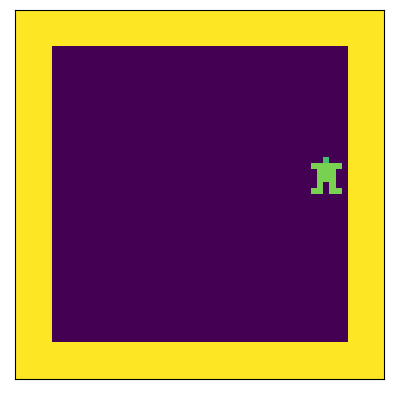

tensor(2, device='cuda:0')


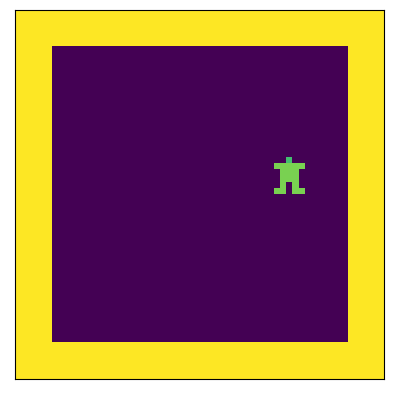

tensor(2, device='cuda:0')


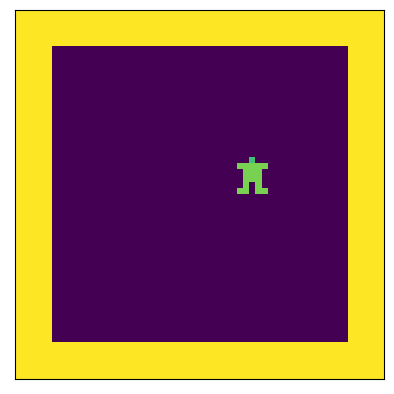

tensor(2, device='cuda:0')


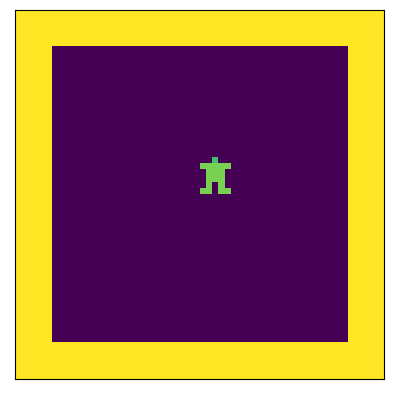

tensor(2, device='cuda:0')


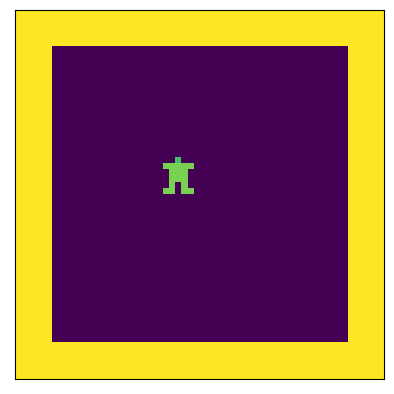

tensor(1, device='cuda:0')


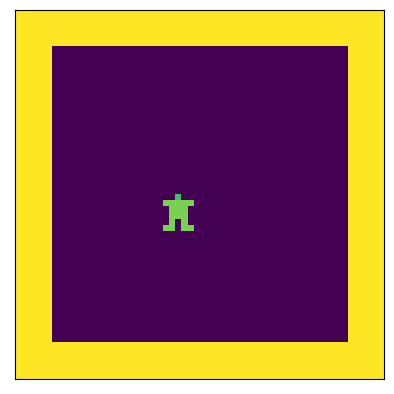

tensor(2, device='cuda:0')


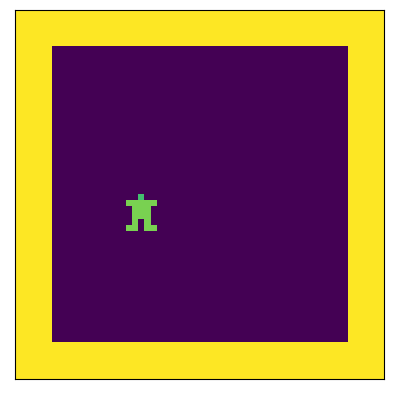

tensor(1, device='cuda:0')


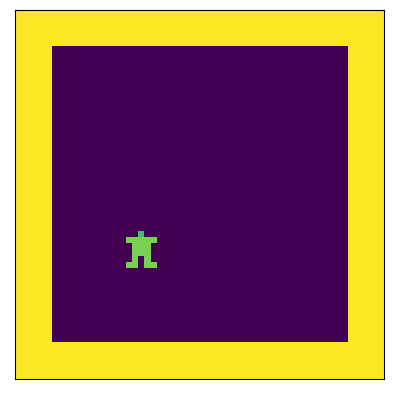

tensor(2, device='cuda:0')


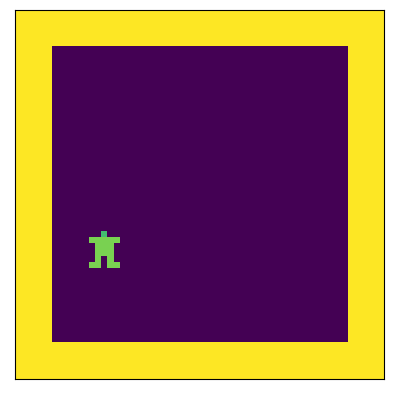

tensor(1, device='cuda:0')


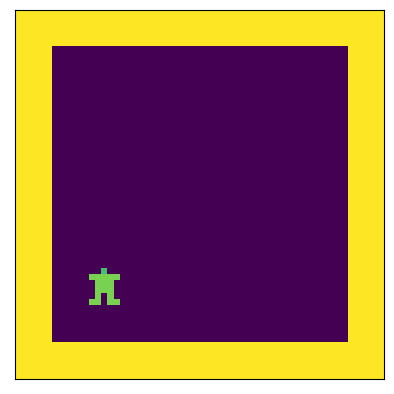

tensor(1, device='cuda:0')


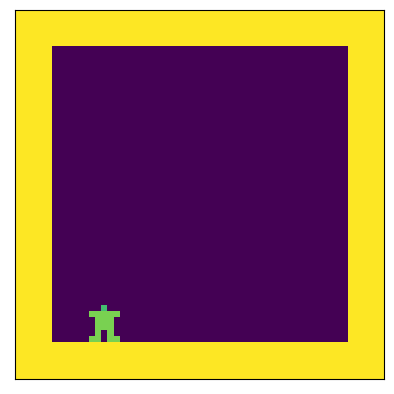

tensor(2, device='cuda:0')


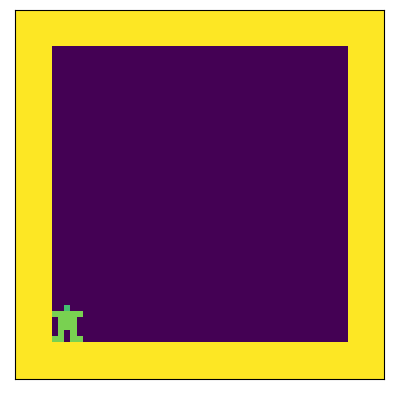

In [90]:
%matplotlib inline

frames = []

for i in range(100):
    obs = env.observe()
    width = height = int(np.sqrt(obs[0].size))
    _obs = obs[0].reshape((width, height))
    plt.figure()
    frame = _obs.squeeze()
    plt.imshow(frame)
    frames.append(frame)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if is_terminal: break
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = (env.inTerminalState() or action ==0)

### As animation

<IPython.core.display.Javascript object>


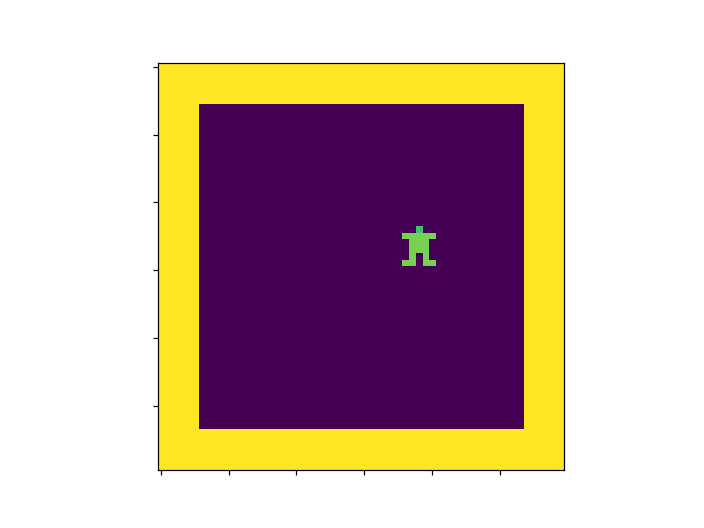

MovieWriter ffmpeg unavailable; using Pillow instead.
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 242, in get_text_width_height_descent
    w /= 64.0  # convert from subpixels
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 242, in get_text_width_height_descent
    w /= 64.0  # convert from subpixels
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/

Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

In [91]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros((height, width)))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    im = ax.imshow(frames[i])
#     obs = env.observe()
#     _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
#     _obs = np.flip(_obs.squeeze())
#     im = ax.imshow(_obs)
#     for i in range(len(obs)):
#         agent._state[i][0:-1] = agent._state[i][1:]
#         agent._state[i][-1] = obs[i]
#         V, action, reward, _ = agent._step()
#         agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=len(frames), blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior_r2_3.gif', writer="ffmpeg", fps = 4)
fig.show()